# This notebook provides a slider to compare different physics parameters

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Dropdown
import ipywidgets as widgets

from parameters_dict import physics_parameters
from exp_analysis_class import exp_analysis

In [18]:
case = 'heavy'
save_folder = (f'../fig/{case}/4_analysis_variables_plots/')
!mkdir -p $save_folder
my_exp_analysis = exp_analysis(case)
my_exp_analysis.load_df_base(1000000)

/bin/bash: port_used: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_port_used'
/bin/bash: wait_until_port_used: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_wait_until_port_used'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_module'
/bin/bash: find_port: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_find_port'
/bin/bash: random_number: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_random_number'
/bin/bash: helmod: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_helmod'
/bin/bash: source_helpers: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_source_h

## Slider for physics distributions

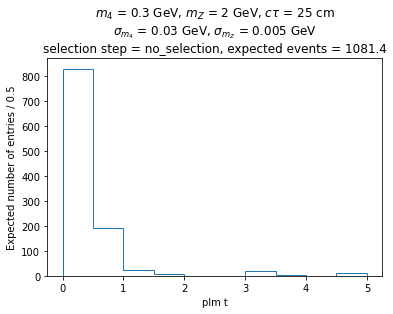

1081.41118015708

In [17]:
@interact(var_1=widgets.Dropdown(
                options=list(my_exp_analysis.df_base.columns.to_frame().loc[:, 0].values),
                description='Variable:',
                disabled=False,
            ),
          var_2=widgets.Dropdown(
                options=list(my_exp_analysis.df_base.columns.to_frame().loc[:, 1].values),
                description='Component:',
                disabled=False,
            ),
          bins=widgets.IntSlider(min=1, max=50, step=1, value=10, continuous_update=False),
          hist_range=widgets.FloatRangeSlider(
                value=[0, 5],
                min=0,
                max=10.0,
                step=0.1,
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.1f',
            ),
          m4=widgets.FloatSlider(min=0.005, max=1, step=0.025, value=0.3, continuous_update=False), 
          mz=widgets.FloatSlider(min=0.005, max=10, step=0.005, value=2, continuous_update=False), 
          ctau=widgets.FloatLogSlider(
                base=10,
                min=-2, # max exponent of base
                max=3, # min exponent of base
                step=0.2, # exponent step
                value=25,
            ),
          kernel=widgets.Dropdown(
                options=['epa', 'gaus'],
                description='Kernel type:',
                disabled=False,
            ),
          smooth_m4=widgets.FloatSlider(min=0.001, max=0.5, step=0.001, value=0.03, continuous_update=False), 
          smooth_mz=widgets.FloatSlider(min=0.001, max=0.5, step=0.001, value=0.005, continuous_update=False), 
          selection_step=widgets.RadioButtons(
                options=['no_selection', 'cut_based', 'geometric', 'geometric_cut_based'],
                value='no_selection',
                description='selection:',
            ),
          df=fixed(my_exp_analysis.df_base))
def output_distrib(df, var_1, var_2, bins, hist_range, m4, mz, ctau, kernel, smooth_m4, smooth_mz, selection_step):
    m4_values = df['m4', ''].values
    mz_values = df['mzprime', ''].values
    df_values = np.stack([m4_values, mz_values], axis=-1)
    this_kde_weights = my_exp_analysis.kde_Nd_weights(np.array([m4, mz]), df_values, smoothing=[smooth_m4, smooth_mz])
    weight_values = this_kde_weights * df['actual_weight', ''].values

    if selection_step == 'no_selection':
        pass
    if 'cut_based' in selection_step:
        weight_values *= df['cut_based', ''].values
    if 'geometric' in selection_step:
        weight_values *= decay_in_tpc(df, ctau)

    plt.hist(df[var_1, var_2],
             range=hist_range,
             bins=bins,
             weights=weight_values,
             histtype='step',
             label=f'kde2D, from $m_4$ in [{m4_values.min():.2g}, {m4_values.max():.2g}], $m_Z$ in [{mz_values.min():.2g}, {mz_values.max():.2g}]\nexpected events = {weight_values.sum():.1f}')
    plt.ylim(bottom=0)
    plt.xlabel(f"{var_1} {var_2}")
    plt.ylabel(f"Expected number of entries / {(hist_range[1]-hist_range[0])/bins:.2g}")
    plt.title(f"$m_4$ = {m4:.2g} GeV, $m_Z$ = {mz:.2g} GeV, $c\\tau$ = {ctau:.2g} cm\n$\sigma_{{m_4}}$ = {smooth_m4:.2g} GeV, $\sigma_{{m_Z}}$ = {smooth_mz:.2g} GeV\nselection step = {selection_step}, expected events = {weight_values.sum():.1f}")
    return weight_values.sum()

## Event rate vs ctau

In [1]:
ctaus = [0.1, 1, 10, 100, 1000]
m4 = 0.12
mz = 1.25

m4_values = my_exp_analysis.df_base['m4', ''].values
mz_values = my_exp_analysis.df_base['mzprime', ''].values
df_values = np.stack([m4_values, mz_values], axis=-1)
smooth_m4, smooth_mz = 0.005, 0.05
this_kde_weights = my_exp_analysis.kde_Nd_weights(np.array([m4, mz]), df_values, smoothing=[smooth_m4, smooth_mz])

variable = ('pee', 't')
selection_step = 'cut_based'
        
my_exp_analysis.decay_in_tpc(my_exp_analysis.df_base, ctaus)
for ctau in ctaus:
    weight_values = this_kde_weights *\
                    my_exp_analysis.df_base['actual_weight', ''].values *\
                    my_exp_analysis.df_base[selection_step, ''].values *\
                    my_exp_analysis.df_base[f'decay_in_tpc_{ctau}', ''].values
    
    out = plt.hist(my_exp_analysis.df_base['pee', 't'], 
                   bins=20, 
                   range=(0, 4),
                   weights=weight_values, 
                   label=f"ctau = {ctau} cm, nevt = {weight_values.sum():.0f} $\pm$ {np.sqrt((weight_values**2).sum()):.0f}", 
                   histtype='step')

plt.legend(frameon=False)
plt.xlabel('e+e- deposited energy [GeV]')
# plt.title(f"Best fit point {model}")
# plt.savefig(save_folder+"ee_energy.png", dpi=250)

NameError: name 'my_exp_analysis' is not defined

Text(0.5, 0, 'e+e- deposited energy [GeV]')

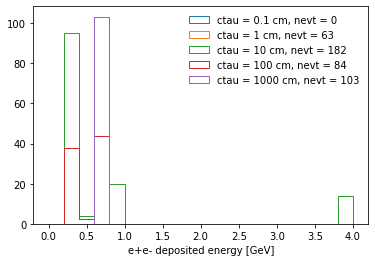

In [30]:
ctaus = [0.1, 1, 10, 100, 1000]
m4 = 0.12
mz = 1.25

m4_values = my_exp_analysis.df_base['m4', ''].values
mz_values = my_exp_analysis.df_base['mzprime', ''].values
df_values = np.stack([m4_values, mz_values], axis=-1)
smooth_m4, smooth_mz = 0.005, 0.05
this_kde_weights = my_exp_analysis.kde_Nd_weights(np.array([m4, mz]), df_values, smoothing=[smooth_m4, smooth_mz])

variable = ('pee', 't')
selection_step = 'cut_based'
        
my_exp_analysis.decay_in_tpc(my_exp_analysis.df_base, ctaus)
for ctau in ctaus:
    weight_values = this_kde_weights *\
                    my_exp_analysis.df_base['actual_weight', ''].values *\
                    my_exp_analysis.df_base[selection_step, ''].values *\
                    my_exp_analysis.df_base[f'decay_in_tpc_{ctau}', ''].values
    
    out = plt.hist(my_exp_analysis.df_base['pee', 't'], 
                   bins=20, 
                   range=(0, 4),
                   weights=weight_values, 
                   label=f"ctau = {ctau} cm, nevt = {weight_values.sum():.0f}", 
                   histtype='step')

plt.legend(frameon=False)
plt.xlabel('e+e- deposited energy [GeV]')
# plt.title(f"Best fit point {model}")
# plt.savefig(save_folder+"ee_energy.png", dpi=250)